In [2]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


!pip install emoji
import emoji 

!pip install shap
import shap as shap

import gc
import os


import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


/home/mareta/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mareta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/mareta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df_balanced = pd.read_csv('datasets/prepped_data/df_balanced.csv')


In [6]:
def preprocessor(data):
  pattern = r'(@\w+)|(#\w+)' # (http://[^"\s]+)|
  data['sentence'].str.replace(pattern, "")
  data['sentence'].str.replace('RT', "")
  data['sentence'].str.replace('AITA', "")
  data['sentence'].str.replace('aita', "")

  data['sentence'].str.replace('bc', "because")

  # remove URLs
  data['sentence'] = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", "", s) for s in data['sentence']]

  # convert (non) emoji smiley faces & emoticons to words
  eyes = '[8:=;]'
  nose = "['`\-~]"

  data['sentence'] = [re.sub(f'{eyes}{nose}*[)]]+|[[(c]+{nose}*{eyes}', 'smile', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[pP]+', 'lolface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[(c\/]+|[)\/]+{nose}*{eyes}', 'sadface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[\|l]+', 'neutralface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[oO$s@&]+', 'otherface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(r'(<3)', 'heart', s) for s in data['sentence']]
  data['sentence'] = [re.sub(r'(</3)', 'brokenheart', s) for s in data['sentence']]

  data['sentence'] = [emoji.demojize(s) for s in data['sentence']]

  # lowercase
  data['sentence'] = [sentence.lower() for sentence in data['sentence']]


  # remove punctuation
  data['sentence'] = [re.sub(r'[^\w\d\s\']+', '', s) for s in data['sentence']]
  # remove digits
  data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if not word.isdigit()]))
  # remove stopwords
  stops = set(stopwords.words('english'))
  data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

  # remove first unnamed:0 column
  data = data.drop('Unnamed: 0', 1)

  return data

preprocessor(df_balanced)


The default value of regex will change from True to False in a future version.
Possible nested set at position 21
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


,sentence,label
0,aita someone interrupts speaking continue spea...,0
1,greeted slap face,0
2,aita demanding tinder date pay half bill amoun...,0
3,son anxious swimming ocean rent movie jaws,0
4,fed tigers prepared human meat butcher,0
...,...,...
97775,roughly young men incel mean they're virgins p...,1
97776,decided build post based worked,1
97777,im sure thread died interest manitoba hope rea...,1
97778,anyone realize said post daddy shooting hand d...,1


In [7]:
  # split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(df_balanced["sentence"], df_balanced["label"])
  
  # create bag-of-words with weights using tfid vectoriser
  # strip accents and remove stop words during vectorisation
  tf=TfidfVectorizer(strip_accents = 'ascii', stop_words='english')
  
  # transform and fit the training set with vectoriser
  X_train_tf = tf.fit_transform(X_train)
  # transform the test set with vectoriser
  X_test_tf = tf.transform(X_test)

In [8]:
# sampling data from the training and test set to reduce time for SHAP
X_train_sample = shap.sample(X_train_tf, 200)
X_test_sample = shap.sample(X_test_tf, 40)

In [16]:
def model(method, data = df_balanced):

  # for RandomForestClassifier
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  max_depth.append(None)

  params = { 
      'LogisticRegression': {'penalty': ['l1','l2', 'none'],
                             'C': [0.001,0.01,0.1,1,10,100,1000], 
                              'solver' : ['liblinear', 'newton-cg']
                             },
            
      'BernoulliNB': {'alpha' : [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]},

      'MultinomialNB': {'alpha' : [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]},

      'SVC' : {'kernel' : ['linear', 'rbf', 'sigmoid'], 
               'gamma' : [0.1, 1, 10, 50, 100]},
            
      'XGBClassifier' : {'booster' : ['gblinear', 'gbtree']},

      'RandomForestClassifier' : {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                                  'max_features': ['auto', 'sqrt'],
                                  'max_depth': max_depth,
                                  'min_samples_split': [2, 5, 10],
                                  'min_samples_leaf': [1, 2, 4],
                                  'bootstrap': [True, False]}
      }

  gs = GridSearchCV(method, params.get(str(type(method)).split(".")[-1][:-2]), cv = 2, scoring = 'accuracy', n_jobs = -1, refit = True, verbose = 5)
  estimator = gs.fit(X_train_tf, y_train)
  %time gs.fit(X_train_tf, y_train)

  print("Best Parameters: \n{}\n".format(gs.best_params_))

  pred = estimator.predict(X_test_tf)
  metrics.f1_score(y_test, pred, average='weighted')
  print("Accuracy: {}%".format(accuracy_score(y_test, pred) * 100))
    
  print(classification_report(y_test, pred))
  cm = confusion_matrix(y_test, pred)
  print('Confusion Matrix : \n' + str(cm))
  ConfusionMatrixDisplay.from_predictions(y_test, pred)
  plot = plt.show()

  return pred, estimator

def generate_output_file(method, filename: str):
  test = pd.read_csv(filename)
  id = test.index.to_list()
  label, estimator = model(method, test)
  gc.collect()
  name, ext = os.path.splitext(os.path.basename(filename))
  out_file = 'results/'  + 'Results_' + str(type(method)).split(".")[-1][:-2] +'_pred' + ext
  output = pd.DataFrame(list(zip(id, list(label))), columns = ['id', 'label'])
  output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
  output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
  return output.head(), estimator

Fitting 2 folds for each of 42 candidates, totalling 84 fits



28 fits failed out of a total of 84.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

---------------------------------

Fitting 2 folds for each of 42 candidates, totalling 84 fits



28 fits failed out of a total of 84.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

---------------------------------

CPU times: user 3.28 s, sys: 1.07 s, total: 4.35 s
Wall time: 6min 16s
Best Parameters: 
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Accuracy: 77.5209654326038%
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     12217
           1       0.76      0.80      0.78     12228

    accuracy                           0.78     24445
   macro avg       0.78      0.78      0.78     24445
weighted avg       0.78      0.78      0.78     24445

Confusion Matrix : 
[[9139 3078]
 [2417 9811]]


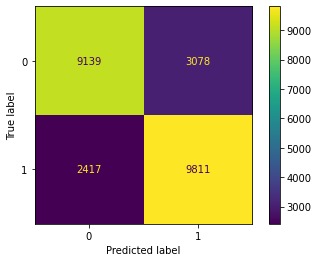

Fitting 2 folds for each of 42 candidates, totalling 84 fits



28 fits failed out of a total of 84.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

---------------------------------

  0%|          | 0/40 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
method = LogisticRegression()
output, estimator = generate_output_file(method, 'gdrive/MyDrive/THESIS/datasets/prepped_data/df_balanced.csv')
               
# delete cache
gc.collect()
               
# get important features (words) with SHAP
model = estimator.fit(X_train_tf, y_train)
               
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(X_test_sample)
               # converting the test samples to a dataframe 
               # this is necessary for non-tabular data in order for the visualisations 
               # to include feature value
               
print("Top words in method : " + str(type(method)).split(".")[-1][:-2])
colour_test = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names())
               
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], colour_test.iloc[1,:], feature_names=tf.get_feature_names_out())
          

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Fitting 2 folds for each of 9 candidates, totalling 18 fits
CPU times: user 159 ms, sys: 18.3 ms, total: 177 ms
Wall time: 647 ms
Best Parameters: 
{'alpha': 0.1}

Accuracy: 74.51421558600941%
              precision    recall  f1-score   support

           0       0.72      0.81      0.76     12217
           1       0.78      0.68      0.73     12228

    accuracy                           0.75     24445
   macro avg       0.75      0.75      0.74     24445
weighted avg       0.75      0.75      0.74     24445

Confusion Matrix : 
[[9927 2290]
 [3940 8288]]


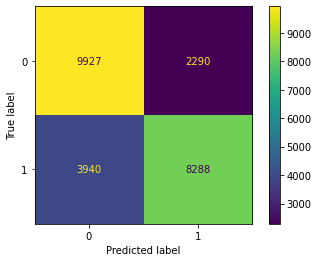

Fitting 2 folds for each of 9 candidates, totalling 18 fits


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/40 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Top words in method : BernoulliNB


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


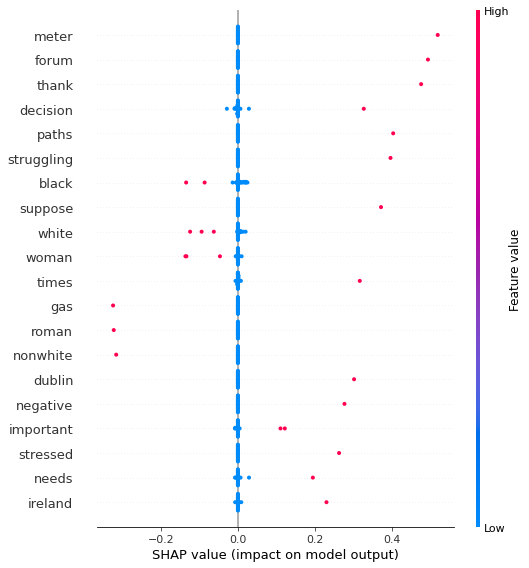

In [ ]:
method = BernoulliNB()
output, estimator = generate_output_file(method, 'gdrive/MyDrive/THESIS/datasets/prepped_data/df_balanced.csv')
               
# delete cache
gc.collect()
               
# get important features (words) with SHAP
model = estimator.fit(X_train_tf, y_train)
               
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(X_test_sample)
# converting the test samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations 
# to include feature value
               
print("Top words in method : " + str(type(method)).split(".")[-1][:-2])
colour_test = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names())
               
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], colour_test.iloc[1,:], feature_names=tf.get_feature_names_out())

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Fitting 2 folds for each of 9 candidates, totalling 18 fits
CPU times: user 145 ms, sys: 15.2 ms, total: 160 ms
Wall time: 531 ms
Best Parameters: 
{'alpha': 0.1}

Accuracy: 75.73327878911843%
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     12217
           1       0.76      0.76      0.76     12228

    accuracy                           0.76     24445
   macro avg       0.76      0.76      0.76     24445
weighted avg       0.76      0.76      0.76     24445

Confusion Matrix : 
[[9250 2967]
 [2965 9263]]


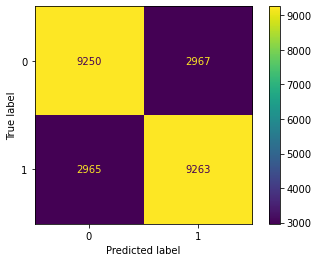

Fitting 2 folds for each of 9 candidates, totalling 18 fits


Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Top words in method : MultinomialNB


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


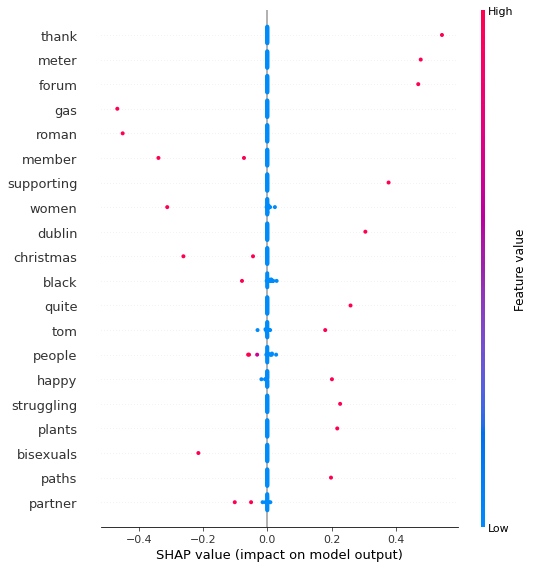

In [ ]:
method = MultinomialNB()
output, estimator = generate_output_file(method, 'gdrive/MyDrive/THESIS/datasets/prepped_data/df_balanced.csv')
               
# delete cache
gc.collect()
               
# get important features (words) with SHAP
model = estimator.fit(X_train_tf, y_train)
               
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(X_test_sample)
               # converting the test samples to a dataframe 
               # this is necessary for non-tabular data in order for the visualisations 
               # to include feature value
               
print("Top words in method : " + str(type(method)).split(".")[-1][:-2])
colour_test = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names())
               
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], colour_test.iloc[1,:], feature_names=tf.get_feature_names_out())

In [12]:
df_balanced.to_csv(r'datasets/prepped_data/df_balanced_prep.csv')

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Fitting 2 folds for each of 15 candidates, totalling 30 fits
CPU times: user 10min 10s, sys: 336 ms, total: 10min 10s
Wall time: 30min 42s
Best Parameters: 
{'gamma': 1, 'kernel': 'rbf'}

Accuracy: 82.41767232562897%
              precision    recall  f1-score   support

           0       0.84      0.80      0.82     12234
           1       0.81      0.85      0.83     12211

    accuracy                           0.82     24445
   macro avg       0.83      0.82      0.82     24445
weighted avg       0.83      0.82      0.82     24445

Confusion Matrix : 
[[ 9773  2461]
 [ 1837 10374]]


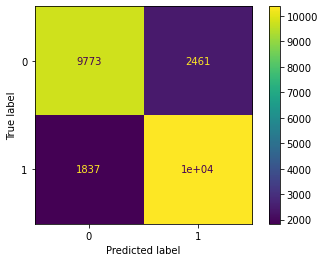

Fitting 2 folds for each of 15 candidates, totalling 30 fits


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/40 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  2%|▎         | 1/40 [41:15<26:49:06, 2475.56s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

Top words in method : SVC


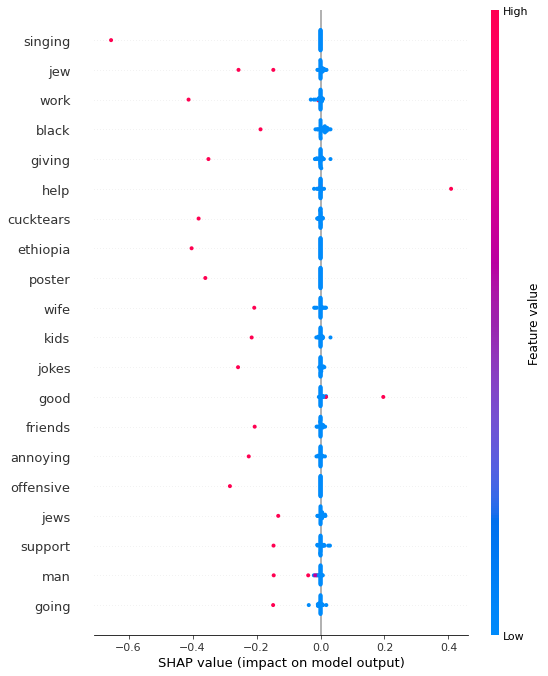

In [17]:
method = SVC()
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced_prep.csv')
               
# delete cache
gc.collect()
               
# get important features (words) with SHAP
model = estimator.fit(X_train_tf, y_train)
               
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(X_test_sample)
               # converting the test samples to a dataframe 
               # this is necessary for non-tabular data in order for the visualisations 
               # to include feature value
               
print("Top words in method : " + str(type(method)).split(".")[-1][:-2])
colour_test = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names())
               
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], colour_test.iloc[1,:], feature_names=tf.get_feature_names_out())

In [ ]:
# did not run the following classifiers (lack of time)

In [ ]:
method = XGBClassifier()
output, estimator = generate_output_file(method, 'gdrive/MyDrive/THESIS/datasets/prepped_data/df_balanced.csv')
               
# delete cache
gc.collect()
               
# get important features (words) with SHAP
model = estimator.fit(X_train_tf, y_train)
               
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(X_test_sample)
               # converting the test samples to a dataframe 
               # this is necessary for non-tabular data in order for the visualisations 
               # to include feature value
               
print("Top words in method : " + str(type(method)).split(".")[-1][:-2])
colour_test = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names())
               
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], colour_test.iloc[1,:], feature_names=tf.get_feature_names_out())

In [ ]:
method = RandomForestClassifier()
output, estimator = generate_output_file(method, 'gdrive/MyDrive/THESIS/datasets/prepped_data/df_balanced.csv')
               
# delete cache
gc.collect()
               
# get important features (words) with SHAP
model = estimator.fit(X_train_tf, y_train)
               
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(X_test_sample)
               # converting the test samples to a dataframe 
               # this is necessary for non-tabular data in order for the visualisations 
               # to include feature value
               
print("Top words in method : " + str(type(method)).split(".")[-1][:-2])
colour_test = pd.DataFrame(X_test_sample.todense())
shap.summary_plot(shap_vals, colour_test, feature_names=tf.get_feature_names())
               
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], colour_test.iloc[1,:], feature_names=tf.get_feature_names_out())